In [1]:
import numpy as np
import scipy as sp
import sklearn as sk
import pandas as pd
import sklearn.cluster as skcluster
# import seaborn as sns

In [126]:
def init_multi(x, K):
    phi = x[np.random.randint(0, x.shape[0], K)]
    phi = phi/np.sum(phi, axis=1).reshape((-1, 1))
    pi = np.ones(K)/K
    return (pi, phi)

def E_multi(x, theta):
    pi, phi = theta
    N, I = x.shape
    K = pi.size
    w = np.log(phi).dot(x.T)+np.log(pi).reshape((-1,1))
    w = w-sp.misc.logsumexp(w, axis=0)
    w = np.exp(w)
    return w

def M_multi(x, w):
    N = x.shape[0]
    phi = w.dot(x)
    phi = phi/phi.sum(axis=1).reshape((-1, 1))
    pi = np.sum(w, axis=1)
    pi = pi/np.sum(pi)
    return (pi, phi)

def init_normal(x, K):
    clusters = skcluster.KMeans(n_clusters=K)
    clusters.fit(x)
    pi = np.bincount(clusters.predict(x))
    mu = clusters.cluster_centers_    
    pi.resize(K)
    pi = (pi/np.sum(pi))*0.9+(0.1/K)
    return (pi, mu)

def E_normal(x, theta):
    pi, mu = theta
    N, I = x.shape
    K = pi.size
    w = -0.5*(np.ones((K,I)).dot((x*x).T)-2*(mu.dot(x.T))+(mu*mu).dot(np.ones((I,N))))
    w += np.log(pi).reshape((-1,1))
    w -= sp.misc.logsumexp(w, axis=0)
    w = np.exp(w)
    return w

def M_normal(x, w):
    N = x.shape[0]
    pi = np.sum(w, axis=1)
    mu = w.dot(x) / pi.reshape((-1, 1))
    pi = pi/np.sum(pi)
    return (pi, mu)
    
def EM(X, k, Estep, Mstep, Init=None, theta=None, iters=40):
    if not theta:
        theta = Init(X, k)
    for i in range(iters):
        e = Estep(X, theta)
        theta = Mstep(X, e)
    return theta

In [119]:
ls test_images/

balloons.jpg     nature.jpg       polarlights.jpg
mountains.jpg    ocean.jpg


In [128]:
from PIL import Image
from matplotlib.pyplot import imshow, figure
%matplotlib inline

pics = ['balloons', 'nature', 'polarlights', 'mountains', 'ocean']
data = {}
dshape = {}
for pic in pics:
    im = Image.open('test_images/%s.jpg'%pic)
    data[pic] = np.asarray(im, dtype=np.float64)
    d = data[pic]
    H,W,_ = data[pic].shape
    dshape[pic] = data[pic].shape
    data[pic] = (data[pic]/256).reshape(H*W, 3)

In [139]:
def display(x, theta, shape):
    N,I = x.shape
    pi, mu = theta
    K = pi.size
    w = -0.5*(np.ones((K,I)).dot((x*x).T)-2*(mu.dot(x.T))+(mu*mu).dot(np.ones((I,N))))
    pos = np.argmax(w, axis=0).reshape(N)
    img = np.zeros((N, 3))
    for i in range(K):
        img[pos==i,:] = mu[i]
    figure()
    
theta = {}
for r in [10, 20, 50]:
    for pic in pics:
        print(r, pic)
        theta[(pic, r)] = init_normal(data[pic], r)  
        display(data[pic], theta[(pic, r)], dshape[pic])

10 balloons
10 nature
10 polarlights
10 mountains
10 ocean
20 balloons
20 nature
20 polarlights
20 mountains
20 ocean
50 balloons
50 nature
50 polarlights
50 mountains
50 ocean


In [71]:

(pi1, mu1) = EM(data, 50, E_normal, M_normal, theta=(pi, mu), iters=1)

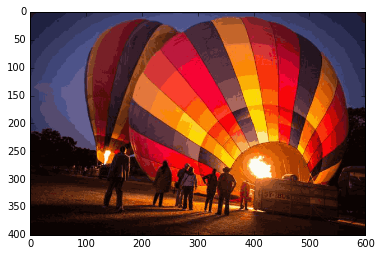

In [72]:
theta2 = {}
for r in [10, 20, 50]:
    for pic in pics:
        theta2[(pic, r)] = EM(data[pic], 50, E_normal, M_normal, theta=theta[(pic,r)], iters=50)
        display(data, theta2[(pic, r)], dshape)

In [74]:
def words():
    file = open('data/docword.nips.txt', 'r')
    D,W,NNZ = (int(file.readline().strip()) for i in range(3))
    X = np.zeros([D,W])
    for line in file:
        n,i,w = tuple(map(int, line.strip().split(' ')))
        X[n-1,i-1] = w
    return X

words = words()+1
pi2,phi2 = init_multi(words, 10)

In [111]:
(pi3, phi3) = EM(words, 30, E_multi, M_multi, theta=(pi2, phi2), iters=4)

In [118]:
voca = np.array([line.strip() for line in open('data/vocab.nips.txt')], dtype='|S20')

In [117]:
def show_topic(colum, n):
    nth = np.partition(-colum,n)[n]
    return sorted(voca[colum>-nth])
def problem3(phi):
    for i in range(phi.shape[0]):
        print(" ".join(map(lambda x: x.decode('utf-8'), show_topic(phi[i], 10))))
problem3(phi2)
print("=======")
problem3(phi3)

cost data early ebd function obd set stopping weight
architecture component distribution information input layer learning network order output
character classes classifier error net neural output recognition training word
compression data energy filter image model mrf number output
algorithm alignment hmm length model protein sequence sequences states
activity diffusion grouping input layer local maxima motion nadel network
committee error network neural output performance signal task training unit
active data learner learning model network neural variance
information input learning neuron point stationary vector weight
camera head input network neural system video
algorithm error function input learning network set training vector weight
component distribution function information input learning model network order output
classifier model network neural recognition set speech system training word
data function information model network neural neuron point signal system
action algorith

[ 0.136       0.01466667  0.04866667  0.172       0.07066667  0.06
  0.16466667  0.156       0.08666667  0.09066667]


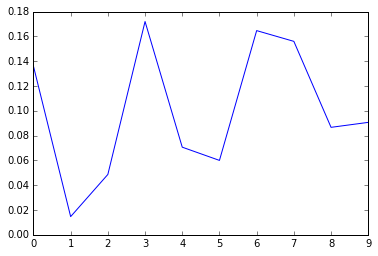

In [156]:
def prob(x, phi, pi):
    w = np.log(phi).dot(x.T)+np.log(pi).reshape((-1,1))
    pos = np.argmax(w, axis=0).reshape(x.shape[0])
    p = np.bincount(pos)
    p = p /sum(p)
    return p
print(prob(words, phi3, pi3))
from matplotlib import pyplot
pyplot.plot(prob(words, phi3, pi3))

In [152]:
# imshow(data[pic].reshape(dshape[(pic, r)]))
data[pic]

array([[ 0.6328125 ,  0.66796875,  0.78125   ],
       [ 0.62890625,  0.6640625 ,  0.77734375],
       [ 0.62890625,  0.6640625 ,  0.77734375],
       ..., 
       [ 0.3046875 ,  0.26171875,  0.17578125],
       [ 0.46875   ,  0.421875  ,  0.3203125 ],
       [ 0.57421875,  0.51953125,  0.4140625 ]])